In [1]:
# !pip install -q tensorflow-ranking

In [2]:
import tensorflow_datasets as tfds
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import Model
import tensorflow_ranking as tfr
from tensorflow.keras import optimizers

import warnings
warnings.filterwarnings("ignore")

c:\Users\vijay.rameshkumar\Anaconda3\envs\myenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\vijay.rameshkumar\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\vijay.rameshkumar\Anaconda3\envs\myenv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


KeyboardInterrupt: 

In [ ]:
positive_samples = pd.read_csv('adj_matrx_v2/02_continent_study_weighted_suppliers_average_profit.csv')
suppliers = positive_samples.suppliers_info.values.tolist()
positive_samples = positive_samples.set_index('suppliers_info')
positive_samples = positive_samples.sort_index()
positive_samples = positive_samples.stack().reset_index()

positive_samples.columns = ['suppliers__ref', 'projects__study_types_subject_ids', 'positive_score']

positive_samples['suppliers__ref'] = positive_samples['suppliers__ref'].astype('str')
positive_samples['positive_score'] = positive_samples['positive_score'].astype('float32')

In [ ]:
target = []

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(positive_samples['suppliers__ref'].values, tf.string),
            tf.cast(positive_samples['projects__study_types_subject_ids'].values, tf.string),
            tf.cast(positive_samples['positive_score'].values, tf.float32)
        )
    )
)

ratings = training_dataset.map(lambda x,y,z: {
    "subject_name": y,
    "supplier_id": x,
    "supplier_rating": z,
})

movies = ratings.map(lambda x:x['subject_name'])

unique_subjects = positive_samples['projects__study_types_subject_ids'].unique()
unique_suppliers = positive_samples['suppliers__ref'].unique()

In [ ]:
subjects = ratings.map(lambda x: x["subject_name"])
suppliers = ratings.map(lambda x: x["supplier_id"])

suppliers_vocabulary = layers.experimental.preprocessing.StringLookup(
    mask_token=None)
suppliers_vocabulary.adapt(suppliers.batch(10))

subjects_vocabulary = layers.experimental.preprocessing.StringLookup(
    mask_token=None)
subjects_vocabulary.adapt(subjects.batch(10))

In [ ]:
key_func = lambda x: suppliers_vocabulary(x["supplier_id"])
reduce_func = lambda key, dataset: dataset.batch(10)
train = ratings.group_by_window(
    key_func=key_func, reduce_func=reduce_func, window_size=10)

In [ ]:
print(train)
for x in train.take(1):
  for key, value in x.items():
    print(f"Shape of {key}: {value.shape}\n")
    print(f"Example values of {key}: {value[:5].numpy()}")
    print()

<_GroupByWindowDataset element_spec={'subject_name': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'supplier_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'supplier_rating': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>
Shape of subject_name: (7,)

Example values of subject_name: [b'b2b' b'community' b'consumer_study' b'healthcare' b'music_study']

Shape of supplier_id: (7,)

Example values of supplier_id: [b'south-america@72' b'south-america@72' b'south-america@72'
 b'south-america@72' b'south-america@72']

Shape of supplier_rating: (7,)

Example values of supplier_rating: [0.05942191 0.         0.         0.         0.        ]



In [ ]:
from typing import Dict, Tuple

def _features_and_labels(
    x: Dict[str, tf.Tensor]) -> Tuple[Dict[str, tf.Tensor], tf.Tensor]:
  labels = x.pop("supplier_rating")
  return x, labels

train = train.map(_features_and_labels)

train = train.apply(
    tf.data.experimental.dense_to_ragged_batch(batch_size=16))

In [ ]:
class RankingModel(Model):
  def __init__(self, user_vocab, movie_vocab):
    super().__init__()

    # Set up user and movie vocabulary and embedding.
    self.user_vocab = user_vocab
    self.movie_vocab = movie_vocab
    self.user_embed = layers.Embedding(user_vocab.vocabulary_size(),
                                                64)
    self.movie_embed = layers.Embedding(movie_vocab.vocabulary_size(),
                                                 64)

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    # Define how the ranking scores are computed: 
    # Take the dot-product of the user embeddings with the movie embeddings.

    embeddings_user= self.user_embed(self.user_vocab(features["supplier_id"]))
    embeddings_movie = self.movie_embed(
        self.movie_vocab(features["subject_name"]))

    return tf.reduce_sum(embeddings_user * embeddings_movie, axis=2)

In [ ]:
epoch = 1000

model = RankingModel(suppliers_vocabulary, subjects_vocabulary)

# optimizer = optimizers.Adagrad(learning_rate=0.001,
#      initial_accumulator_value=0.1,
#      epsilon=1e-07,)

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tfr.keras.losses.get(
    loss=tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS, ragged=True)

eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=True),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=True)
]

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)
checkpoint = tf.keras.callbacks.ModelCheckpoint('LTR_Continent_study_final_model_weights/', \
    save_best_only=True, monitor='metric/ndcg', mode='max')

model.compile(optimizer=optimizer, loss=loss, metrics=eval_metrics)

history = model.fit(train, epochs=epoch, callbacks=[callback, checkpoint])

In [ ]:
epoch = 1000

model = RankingModel(suppliers_vocabulary, subjects_vocabulary)

# optimizer = optimizers.Adagrad(learning_rate=0.001,
#      initial_accumulator_value=0.1,
#      epsilon=1e-07,)

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tfr.keras.losses.get(
    loss=tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS, ragged=True)

eval_metrics = [
    tfr.keras.metrics.get(key="map", name="metric/map", ragged=True),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=True),
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=True)
]

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

checkpoint = tf.keras.callbacks.ModelCheckpoint('LTR_Continent_study_map_final_model_weights/', \
    save_best_only=True, monitor='metric/map', mode='max')

model.compile(optimizer=optimizer, loss=loss, metrics=eval_metrics)

history = model.fit(train, epochs=epoch, callbacks=[callback, checkpoint])

Text(0, 0.5, 'loss')

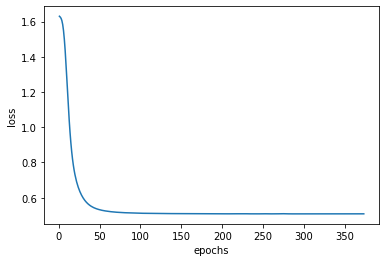

In [ ]:
import seaborn as sns

epochs = list(range(1,len(list(history.history['loss']))+1))

loss = history.history['loss']

g = sns.lineplot(epochs, loss, legend= True);
g.set_xlabel('epochs')
g.set_ylabel('loss')

Text(0, 0.5, 'ndcg score')

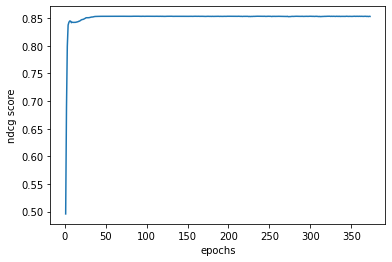

In [ ]:
g = sns.lineplot(epochs, history.history['metric/ndcg'], legend= True);
g.set_xlabel('epochs')
g.set_ylabel('ndcg score')

Text(0, 0.5, 'mrr score')

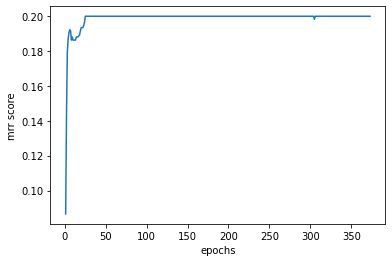

In [ ]:
g = sns.lineplot(epochs, history.history['metric/mrr'], legend= True);
g.set_xlabel('epochs')
g.set_ylabel('mrr score')

In [ ]:
# Get supplier candidate list.
# for supplier_id in ratings.batch(20):
#   break

# Generate the input for user 42.
inputs = {
    "subject_name":
        tf.expand_dims(tf.repeat('banking_financial', repeats=tf.convert_to_tensor(unique_suppliers).shape[0]), axis=0),
    "supplier_id":
        tf.expand_dims(tf.convert_to_tensor(unique_suppliers), axis=0)
}

# Get movie recommendations for user 42.
scores = model(inputs)
IDS = tfr.utils.sort_by_scores(scores,
                                  [tf.expand_dims(tf.convert_to_tensor(unique_suppliers), axis=0)])[0]

print(f"Top 10 recommendations for subject  'banking_financial': {IDS[0, :10]}")

Top 10 recommendations for subject  'banking_financial': [b'asia@549' b'europe@574' b'europe@593' b'europe@341' b'europe@301'
 b'north-america@561' b'north-america@592' b'north-america@124'
 b'north-america@468' b'north-america@448']


## saving weights

In [ ]:
# import os

# if not os.path.exists('final_model_weights'):
#     os.makedirs('final_model_weights')
    
# model.save_weights('final_model_weights/')

## Loading Weights

In [ ]:
D = RankingModel(suppliers_vocabulary, subjects_vocabulary)

optimizer = optimizers.Adagrad(0.5)

loss = tfr.keras.losses.get(
    loss=tfr.keras.losses.RankingLossKey.SOFTMAX_LOSS, ragged=True)

eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=True),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=True)
]

D.compile(optimizer=optimizer, loss=loss, metrics=eval_metrics)

D.load_weights('LTR_Continent_study_final_model_weights/')

In [ ]:
# Generate the input for inferance.
inputs = {
    "subject_name":
        tf.expand_dims(tf.repeat('banking_financial', repeats=tf.convert_to_tensor(unique_suppliers).shape[0]), axis=0),
    "supplier_id":
        tf.expand_dims(tf.convert_to_tensor(unique_suppliers), axis=0)
}

# Get movie recommendations.
scores = D(inputs)
IDS = tfr.utils.sort_by_scores(scores,
                                  [tf.expand_dims(tf.convert_to_tensor(unique_suppliers), axis=0)])[0]
print(f"Top 10 recommendations for subject  'banking_financial': {IDS[0, :50]}")

Top 10 recommendations for subject  'banking_financial': [b'europe@442' b'south-america@561' b'north-america@585' b'asia@586'
 b'north-america@370' b'oceania@113' b'asia@543' b'north-america@295'
 b'south-america@293' b'north-america@459' b'europe@487'
 b'north-america@484' b'south-america@388' b'south-america@490'
 b'north-america@359' b'asia@442' b'north-america@383' b'oceania@524'
 b'asia@293' b'oceania@72' b'europe@572' b'europe@373'
 b'south-america@572' b'north-america@341' b'north-america@436'
 b'oceania@442' b'oceania@183' b'north-america@474' b'europe@460'
 b'europe@558' b'europe@388' b'oceania@592' b'oceania@593' b'europe@438'
 b'north-america@520' b'south-america@591' b'north-america@288'
 b'oceania@543' b'oceania@562' b'north-america@371' b'asia@58' b'asia@592'
 b'oceania@58' b'north-america@137' b'north-america@588'
 b'north-america@460' b'north-america@353' b'south-america@565'
 b'oceania@341' b'oceania@388']
